# Production-Level Monte Carlo Simulation for Stock Portfolio

## Introduction

This notebook performs a Monte Carlo simulation to project the future value of a stock portfolio. The code is organized into functions, includes input validation, error handling, logging, and reads parameters from a configuration file. This structure enhances readability, maintainability, and is closer to production-level quality.


## Setup and Configuration

We will start by importing necessary libraries and setting up logging. The configuration parameters are read from an external YAML file.


In [17]:
# Install required libraries
%pip install yfinance PyYAML seaborn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import logging
import yaml
import sys
import os

from datetime import datetime


Note: you may need to restart the kernel to use updated packages.


## Setup and Configuration

We will start by setting up logging and loading configuration parameters from an external YAML file.


In [18]:
# Configure logging
logging.basicConfig(
    filename='monte_carlo_simulation.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)


In [19]:
# Load configuration parameters from YAML file
def load_config(config_file='config.yaml'):
    """
    Load simulation parameters from a YAML configuration file.
    
    Parameters:
    - config_file (str): Path to the configuration YAML file.
    
    Returns:
    - config (dict): Dictionary containing configuration parameters.
    """
    try:
        with open(config_file, 'r') as file:
            config = yaml.safe_load(file)
            logging.info("Configuration file loaded successfully.")
            return config
    except Exception as e:
        logging.error(f"Error loading configuration file: {e}")
        sys.exit(f"Error loading configuration file: {e}")


### Configuration File (`config.yaml`)

Create a file named `config.yaml` in the same directory as your notebook with the following content:

```yaml
stocks:
  - AAPL
  - MSFT
  - GOOGL
weights:
  - 0.4
  - 0.35
  - 0.25
initial_investment: 100000
num_simulations: 10000
time_horizon: 252
confidence_level: 0.95
data_period: '5y'
risk_free_rate: 0.02  # Annual risk-free rate (e.g., 2%)

## Defining Functions

We will define functions for each major step: fetching data, calculating returns, running simulations, analyzing results, and plotting.


In [20]:
def validate_inputs(config):
    """
    Validate the inputs from the configuration file.
    
    Parameters:
    - config (dict): Configuration parameters.
    
    Returns:
    - None
    
    Raises:
    - ValueError: If any input is invalid.
    """
    try:
        stocks = config['stocks']
        weights = config['weights']
        initial_investment = config['initial_investment']
        num_simulations = config['num_simulations']
        time_horizon = config['time_horizon']
        confidence_level = config['confidence_level']
        
        if not stocks or not isinstance(stocks, list):
            raise ValueError("Stocks list is empty or invalid.")
        if not weights or not isinstance(weights, list):
            raise ValueError("Weights list is empty or invalid.")
        if len(stocks) != len(weights):
            raise ValueError("The number of stocks and weights must be equal.")
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1.")
        if initial_investment <= 0:
            raise ValueError("Initial investment must be greater than 0.")
        if num_simulations <= 0:
            raise ValueError("Number of simulations must be greater than 0.")
        if time_horizon <= 0:
            raise ValueError("Time horizon must be greater than 0.")
        if not (0 < confidence_level < 1):
            raise ValueError("Confidence level must be between 0 and 1.")
        
        logging.info("Input validation passed.")
    except ValueError as ve:
        logging.error(f"Input validation error: {ve}")
        sys.exit(f"Input validation error: {ve}")
    except KeyError as ke:
        logging.error(f"Missing configuration parameter: {ke}")
        sys.exit(f"Missing configuration parameter: {ke}")
    except Exception as e:
        logging.error(f"Unexpected error during input validation: {e}")
        sys.exit(f"Unexpected error during input validation: {e}")


In [21]:
def fetch_data(stocks, period):
    """
    Fetch historical adjusted closing prices for the given stocks.
    
    Parameters:
    - stocks (list): List of stock tickers.
    - period (str): Period over which to fetch data (e.g., '5y').
    
    Returns:
    - data (DataFrame): DataFrame containing adjusted closing prices.
    """
    try:
        data = yf.download(stocks, period=period)['Adj Close']
        logging.info("Historical stock data fetched successfully.")
        return data
    except Exception as e:
        logging.error(f"Error fetching stock data: {e}")
        sys.exit(f"Error fetching stock data: {e}")


In [22]:
def calculate_returns(data):
    """
    Calculate daily returns from adjusted closing prices.
    
    Parameters:
    - data (DataFrame): DataFrame of adjusted closing prices.
    
    Returns:
    - returns (DataFrame): DataFrame of daily returns.
    """
    try:
        returns = data.pct_change().dropna()
        logging.info("Daily returns calculated successfully.")
        return returns
    except Exception as e:
        logging.error(f"Error calculating daily returns: {e}")
        sys.exit(f"Error calculating daily returns: {e}")


In [23]:
def calculate_parameters(returns):
    """
    Calculate mean daily returns and covariance matrix.
    
    Parameters:
    - returns (DataFrame): DataFrame of daily returns.
    
    Returns:
    - mean_returns (Series): Mean daily returns.
    - cov_matrix (DataFrame): Covariance matrix of returns.
    """
    try:
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        logging.info("Mean returns and covariance matrix calculated successfully.")
        return mean_returns, cov_matrix
    except Exception as e:
        logging.error(f"Error calculating parameters: {e}")
        sys.exit(f"Error calculating parameters: {e}")


In [24]:
def run_simulation(initial_investment, mean_returns, cov_matrix, weights, num_simulations, time_horizon):
    """
    Run Monte Carlo simulation for the portfolio.
    
    Parameters:
    - initial_investment (float): Initial amount invested.
    - mean_returns (Series): Mean daily returns.
    - cov_matrix (DataFrame): Covariance matrix of returns.
    - weights (ndarray): Portfolio weights.
    - num_simulations (int): Number of simulation runs.
    - time_horizon (int): Time horizon in days.
    
    Returns:
    - simulation_results (ndarray): Array of simulation results.
    """
    try:
        np.random.seed(42)  # For reproducibility
        portfolio_mean = mean_returns @ weights
        portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
        
        simulation_results = np.zeros((num_simulations, time_horizon))
        
        for i in range(num_simulations):
            daily_returns = np.random.normal(portfolio_mean, portfolio_std, time_horizon)
            cumulative_returns = np.cumprod(1 + daily_returns) * initial_investment
            simulation_results[i, :] = cumulative_returns
        
        logging.info("Monte Carlo simulation completed successfully.")
        return simulation_results
    except Exception as e:
        logging.error(f"Error during simulation: {e}")
        sys.exit(f"Error during simulation: {e}")


In [25]:
def analyze_results(simulation_results, initial_investment, confidence_level, risk_free_rate, time_horizon):
    """
    Analyze the simulation results and calculate risk metrics.
    """
    try:
        final_portfolio_values = simulation_results[:, -1]
        mean_final_value = np.mean(final_portfolio_values)
        median_final_value = np.median(final_portfolio_values)
        std_final_value = np.std(final_portfolio_values)
        
        # Calculate portfolio returns over the time horizon
        portfolio_returns = (final_portfolio_values - initial_investment) / initial_investment
        
        # Annualized return and volatility
        annualized_return = np.mean(portfolio_returns) * (252 / time_horizon)
        annualized_volatility = np.std(portfolio_returns) * np.sqrt(252 / time_horizon)
        
        # Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
        
        # Maximum Drawdown
        drawdowns = simulation_results / np.maximum.accumulate(simulation_results, axis=1) - 1
        max_drawdown = np.min(drawdowns)
        
        # Value at Risk (VaR)
        var_percentile = np.percentile(final_portfolio_values, (1 - confidence_level) * 100)
        VaR = initial_investment - var_percentile
        
        # Conditional Value at Risk (CVaR)
        cvar_values = final_portfolio_values[final_portfolio_values <= var_percentile]
        CVaR = initial_investment - np.mean(cvar_values)
        
        stats = {
            'mean_final_value': mean_final_value,
            'median_final_value': median_final_value,
            'std_final_value': std_final_value,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'VaR': VaR,
            'CVaR': CVaR
        }
        
        logging.info("Simulation results analyzed successfully.")
        return stats
    except Exception as e:
        logging.error(f"Error analyzing simulation results: {e}")
        sys.exit(f"Error analyzing simulation results: {e}")


In [26]:
def plot_simulation_results(simulation_results):
    """
    Plot the results of the Monte Carlo simulation.
    
    Parameters:
    - simulation_results (ndarray): Array of simulation results.
    
    Returns:
    - None
    """
    try:
        plt.figure(figsize=(15, 6))
        plt.plot(simulation_results.T, color='blue', alpha=0.01)
        plt.title('Monte Carlo Simulation of Portfolio Returns')
        plt.xlabel('Days')
        plt.ylabel('Portfolio Value ($)')
        plt.show()
        logging.info("Simulation results plotted successfully.")
    except Exception as e:
        logging.error(f"Error plotting simulation results: {e}")
        sys.exit(f"Error plotting simulation results: {e}")


In [27]:
def plot_distribution(final_portfolio_values):
    """
    Plot the distribution of final portfolio values.
    """
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(final_portfolio_values, bins=50, kde=True)
        plt.title('Distribution of Final Portfolio Values')
        plt.xlabel('Final Portfolio Value ($)')
        plt.ylabel('Frequency')
        plt.show()
        logging.info("Distribution plot created successfully.")
    except Exception as e:
        logging.error(f"Error plotting distribution: {e}")
        sys.exit(f"Error plotting distribution: {e}")

In [28]:
def plot_confidence_intervals(simulation_results, confidence_level):
    """
    Plot mean, median, and confidence intervals over time.
    """
    try:
        time_horizon = simulation_results.shape[1]
        time = np.arange(1, time_horizon + 1)
        
        # Calculate statistics
        mean = np.mean(simulation_results, axis=0)
        median = np.median(simulation_results, axis=0)
        lower_bound = np.percentile(simulation_results, (1 - confidence_level) * 100, axis=0)
        upper_bound = np.percentile(simulation_results, confidence_level * 100, axis=0)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(time, mean, label='Mean', color='blue')
        plt.plot(time, median, label='Median', color='green')
        plt.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.3, label=f'{int(confidence_level*100)}% Confidence Interval')
        plt.title('Portfolio Value Over Time with Confidence Interval')
        plt.xlabel('Days')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.show()
        logging.info("Confidence interval plot created successfully.")
    except Exception as e:
        logging.error(f"Error plotting confidence intervals: {e}")
        sys.exit(f"Error plotting confidence intervals: {e}")


In [29]:
def plot_cumulative_probability(final_portfolio_values, initial_investment):
    """
    Plot the cumulative probability of achieving at least a certain portfolio value.
    """
    try:
        sorted_values = np.sort(final_portfolio_values)
        cumulative_probs = np.linspace(0, 1, len(sorted_values))
        
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_values, 1 - cumulative_probs)
        plt.title('Cumulative Probability of Final Portfolio Values')
        plt.xlabel('Final Portfolio Value ($)')
        plt.ylabel('Probability of Exceedance')
        plt.grid(True)
        plt.show()
        logging.info("Cumulative probability plot created successfully.")
    except Exception as e:
        logging.error(f"Error plotting cumulative probability: {e}")
        sys.exit(f"Error plotting cumulative probability: {e}")

In [30]:
def display_results(stats, confidence_level):
    """
    Display the calculated statistics from the simulation.
    """
    try:
        print(f"Mean Final Portfolio Value: ${stats['mean_final_value']:,.2f}")
        print(f"Median Final Portfolio Value: ${stats['median_final_value']:,.2f}")
        print(f"Standard Deviation: ${stats['std_final_value']:,.2f}")
        print(f"Annualized Return: {stats['annualized_return'] * 100:.2f}%")
        print(f"Annualized Volatility: {stats['annualized_volatility'] * 100:.2f}%")
        print(f"Sharpe Ratio: {stats['sharpe_ratio']:.2f}")
        print(f"Maximum Drawdown: {stats['max_drawdown'] * 100:.2f}%")
        print(f"{confidence_level * 100}% VaR: ${stats['VaR']:,.2f}")
        print(f"{confidence_level * 100}% CVaR: ${stats['CVaR']:,.2f}")
        logging.info("Results displayed successfully.")
    except Exception as e:
        logging.error(f"Error displaying results: {e}")
        sys.exit(f"Error displaying results: {e}")

## Main Execution

Now, we'll use the functions we've defined to perform the simulation.


In [31]:
def main():
    # Load configuration
    config = load_config()
    
    # Validate inputs
    validate_inputs(config)
    
    # Extract parameters
    stocks = config['stocks']
    weights = np.array(config['weights'])
    initial_investment = config['initial_investment']
    num_simulations = config['num_simulations']
    time_horizon = config['time_horizon']
    confidence_level = config['confidence_level']
    data_period = config.get('data_period', '5y')  # Default to '5y' if not specified
    risk_free_rate = config.get('risk_free_rate', 0.0)
    
    # Fetch data
    data = fetch_data(stocks, data_period)
    
    # Calculate returns
    returns = calculate_returns(data)
    
    # Calculate parameters
    mean_returns, cov_matrix = calculate_parameters(returns)
    
    # Run simulation
    simulation_results = run_simulation(
        initial_investment,
        mean_returns,
        cov_matrix,
        weights,
        num_simulations,
        time_horizon
    )
    
    # Analyze results
    stats = analyze_results(simulation_results, initial_investment, confidence_level, risk_free_rate, time_horizon)
    
    # Plot results
    plot_simulation_results(simulation_results)
    plot_distribution(simulation_results[:, -1])
    plot_confidence_intervals(simulation_results, confidence_level)
    plot_cumulative_probability(simulation_results[:, -1], initial_investment)
    
    # Display results
    display_results(stats, confidence_level)


[*********************100%***********************]  3 of 3 completed


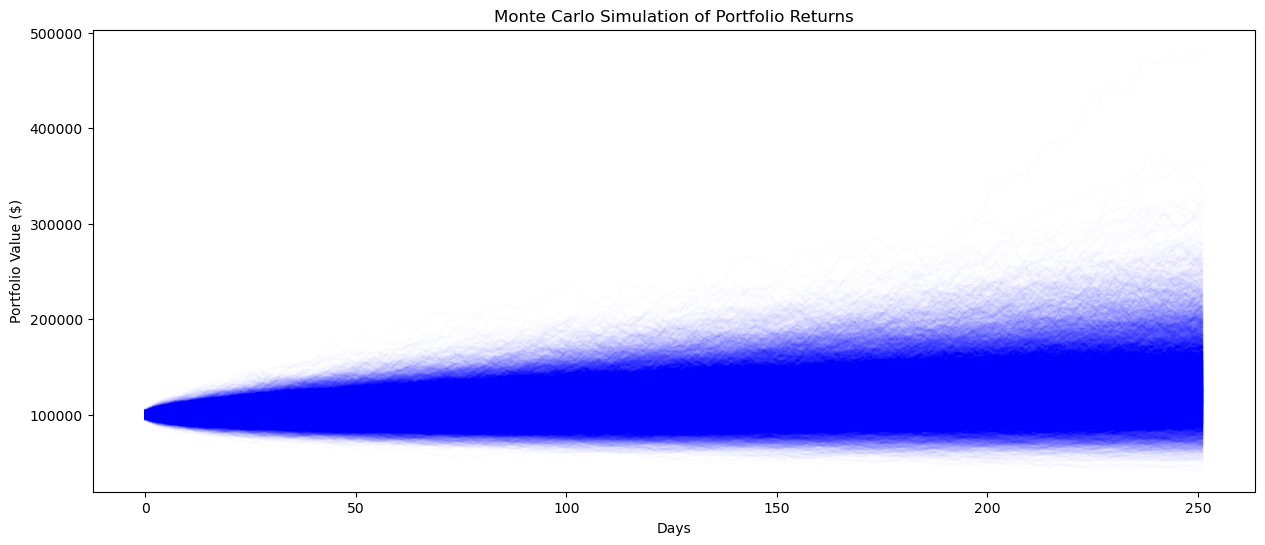

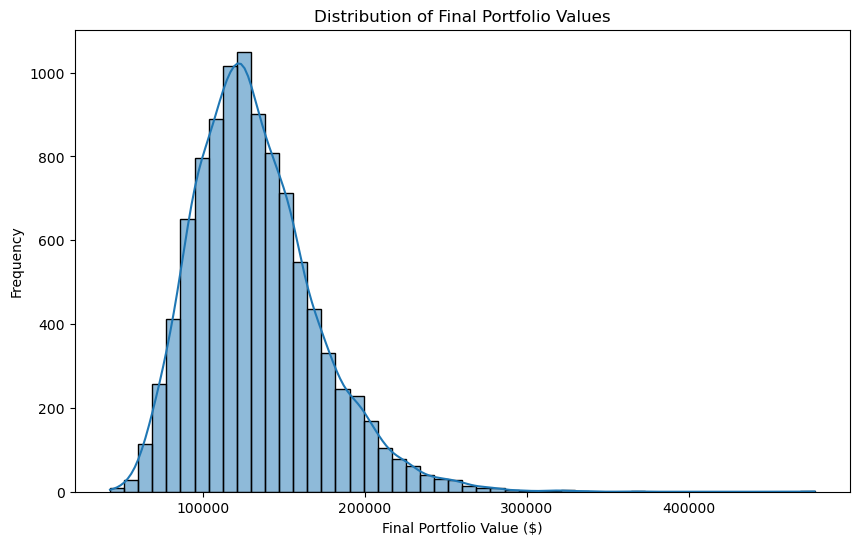

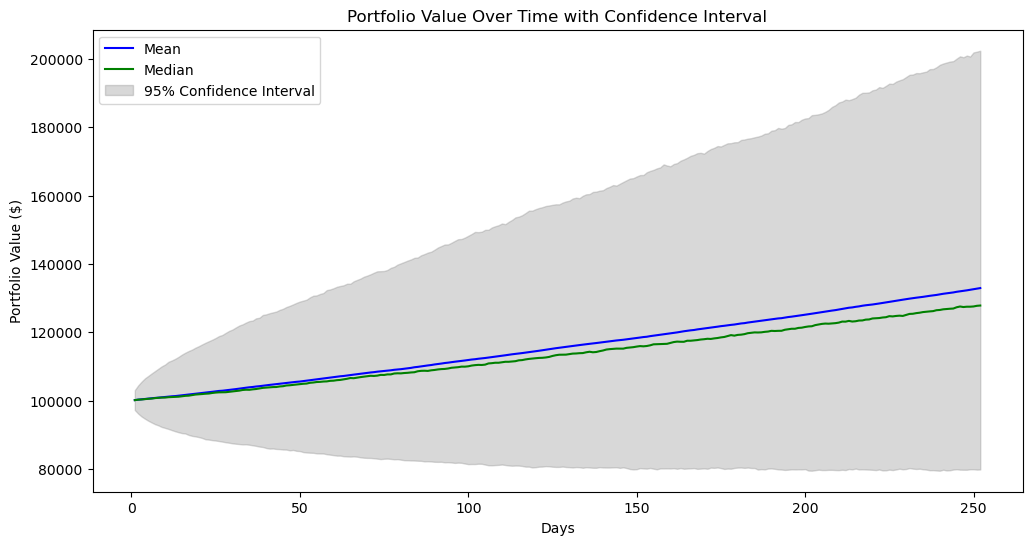

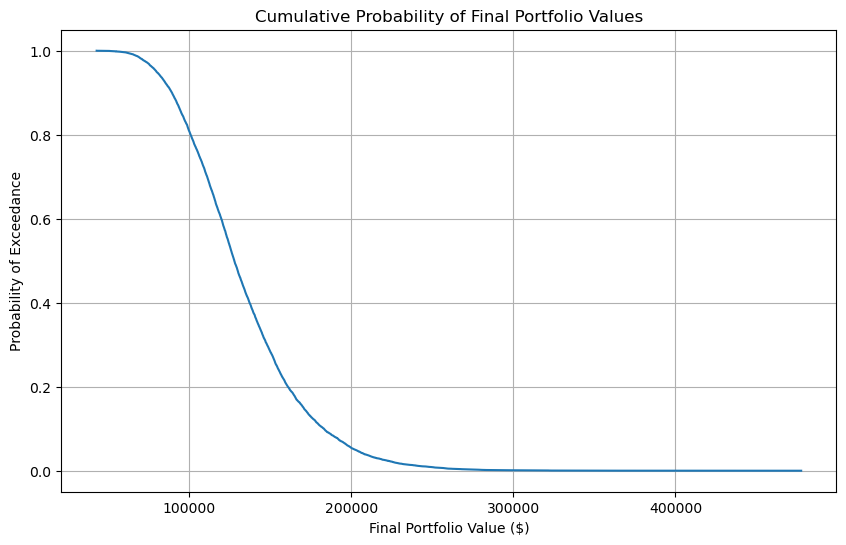

Mean Final Portfolio Value: $132,923.43
Median Final Portfolio Value: $127,814.47
Standard Deviation: $37,966.82
Annualized Return: 32.92%
Annualized Volatility: 37.97%
Sharpe Ratio: 0.87
Maximum Drawdown: -61.43%
95.0% VaR: $20,185.87
95.0% CVaR: $28,698.35


In [32]:
# Execute the main function
if __name__ == "__main__":
    main()


## Additional Notes

- **Histogram of Final Portfolio Values**: Shows the distribution of possible ending portfolio values, indicating the probability of different outcomes.
- **Confidence Interval Plot**: Visualizes the range within which a certain percentage of simulations fall, helping to understand the variability over time.
- **Cumulative Probability Plot**: Illustrates the probability of achieving at least a certain portfolio value, useful for setting investment goals.
- **Additional Risk Metrics**: Including Sharpe Ratio and Maximum Drawdown provides more insight into risk-adjusted returns and potential losses.
- **Seaborn Library**: Used for enhanced plotting capabilities, particularly for the histogram with kernel density estimation.

## Potential Enhancements

To further improve the analysis:

- **Scenario Analysis**: Simulate specific market scenarios to see how the portfolio might perform under different conditions.
- **Sensitivity Analysis**: Assess how changes in inputs (e.g., weights, expected returns) affect the outcomes.
- **Portfolio Optimization**: Use optimization techniques to find the optimal portfolio allocation based on risk and return preferences.
- **Interactive Visualizations**: Incorporate interactive plots using libraries like Plotly for a more engaging analysis.
